In [2]:
import os
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from samplers import get_data_sampler, sample_transformation
from tasks import get_task_sampler
from models import LeastSquaresModel
from matplotlib.ticker import MaxNLocator

import numpy as np
from scipy.signal import savgol_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'whitegrid')
palette = sns.color_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
run_dir = "/Users/harmonbhasin/College/Research/huLab/final_code/curriculum_learning_icl/models"
df = read_run_dir(run_dir)

In [5]:
def run_evaluation(subset_models, task_args, data_args, seed, att_mask=None):
    models = {}
    configs = {}
    n_points = 100
    n_dims = 20
    b_size = 64

    for key in subset_models:
        task = df.task[subset_models[key]]
        run_id = df.run_id[subset_models[key]]
        run_path = os.path.join(run_dir, task, run_id)
        models[key], configs[key] = get_model_from_run(run_path)

    preDict = {}
    yDict = {}

    for task_key in task_args:
        current_task = task_args[task_key]
        task_sampler = get_task_sampler(
            current_task['task'],
            n_dims,
            b_size,
            **{i: current_task[i] for i in current_task if i != 'task'}
        )
        print('Conducting evaluation on', current_task['task'], 'with degree of ', current_task['degree'], '\n')
        for data_key in data_args:
            torch.manual_seed(seed)
            current_data = data_args[data_key]
            sample_args = {}

            if current_data['type'] == 'Skewed':
                eigenvals = 1 / (torch.arange(n_dims) + 1)
                scale = sample_transformation(eigenvals, normalize=True)
                sample_args['scale'] = scale

            for data_info in current_data:
                if data_info != 'data' and data_info != 'type':
                    sample_args[data_info] = current_data[data_info]

            data_sampler = get_data_sampler(current_data['data'], n_dims, **sample_args)

            # Create an instance of the function class sampler; add seed stuff here
            task = task_sampler()

            # Generate x points; add seed stuff here
            xs = data_sampler.sample_xs(n_points, b_size)

            # Generate y points
            ys = task.evaluate(xs)

            yDict[f"{task_key}_{data_key}"] = ys

            for model_key in models:
                prompt_col = 0
                prompt_row = 0
                conf = configs[model_key]['training']
                prompt_args = conf['prompt_kwargs']
                if len(prompt_args) != 0:
                       if prompt_args['type'] == 'data':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(data_key[-1])
                           prompt_col = prompt_args['position']
                       elif prompt_args['type'] == 'task':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(task_key[-1])
                           prompt_col = prompt_args['position']

                temp_key = f"{model_key}_{task_key}_{data_key}"
                with torch.no_grad():
                    if att_mask is None:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col)
                    else:
                        _, _, preDict[temp_key] = models[model_key](xs,
                                                            ys,
                                                            conf['prompt_type'],
                                                            prompt_row,
                                                            prompt_col,
                                                            att_mask=att_mask)

                    if conf['prompt_type'] == 'standard':
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution')
                    else:
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution with instruction in row', prompt_row, 'and column', prompt_col)
    lossDict = {}
    for pred_key in preDict:
        for y_key in yDict:
            if y_key in pred_key:
                lossDict[pred_key] = (yDict[y_key] - preDict[pred_key]).square().numpy()

    different_plots = {}

    for key in lossDict:
        components = key.split('_')
        model = components[0]
        task = components[1]
        data = components[2]
        task_data = f"{task}_{data}"
        if task_data not in different_plots:
            different_plots[task_data] = {}
        different_plots[task_data][model] = lossDict[key]

    return different_plots, configs

In [28]:
from matplotlib.ticker import FuncFormatter
def format_y_axis(value, _):
    return f'{value:.2e}'  # Format in scientific notation with two decimal places


def plot_results_horizontal_individual(different_plots, configs,task_args, data_args, type, head_dir, smooth, window_size = 10, limit_y=False, y_lim_low=[-0.1,-0.1, -0.1], y_lim_high=[1.0,1.0,1.0], width=12,height=4, legend=False, include_title=False, grid=False, scinot=False, force_ticks=False, format_two=False, name=None):
    sns.set_palette("Set3")
    color_index = 0
    for key in configs:
        if key != 'OLS':
            if 'Mixed' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Mixed model'
            elif 'Random' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Random model'
            elif 'Sequential' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Sequential model'
            elif 'Skewed Gaussian' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Skewed gaussian model'
            elif 'Gaussian' in configs[key]['wandb']['name'] and type == 'task':
                configs[key]['name'] = 'Linear model'
            elif 'Gaussian' in configs[key]['wandb']['name'] and type == 'sample':
                configs[key]['name'] = 'Gaussian model'
            elif 'Binomial' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Quadratic model'
            elif 'Trinomial' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Cubic model'
            elif 'Student-T' in configs[key]['wandb']['name']:
                configs[key]['name'] = 'Student t model'
          


            if configs[key]['training']['prompt_type'] != 'standard':
                configs[key]['ls'] = 'dashed'
            else:
                configs[key]['ls'] = 'solid'
            configs[key]['c'] = sns.color_palette()[color_index]
            color_index +=1

    configs['OLS'] = {}
    configs['OLS']['name'] = 'Least Squares'
    configs['OLS']['ls'] = 'dashdot'
    configs['OLS']['c'] = 'black'

    num_cols = len(different_plots)

    plt.style.use('seaborn-whitegrid')
    model_dict = {}
    for index, task_data in enumerate(different_plots):
        for model in different_plots[task_data]:
            if model not in model_dict:
                _, model_dict[model] = plt.subplots(nrows=1, ncols=num_cols, figsize=(width,height), tight_layout=True)
            
            if smooth:
                    # Moving average via ChatGPT
                    smoothed_data = np.convolve(different_plots[task_data][model].mean(axis=0)/20, np.ones((window_size,))/window_size, mode='valid')
                    model_dict[model][index].plot(smoothed_data,
                                    lw=2,
                                    label=f"{configs[model]['name']} (MA)",
                                    color='#d95f02')
                    model_dict[model][index].plot(different_plots[task_data][model].mean(axis=0)/20,
                                    lw=2,
                                    label=configs[model]['name'],
                                    color='#7570b3',
                                    ls='dotted')
                    #model_dict[model][index].set_title(f"{configs[model]['name']}")
    for key in model_dict:
        if grid == False:
            model_dict[key][2].legend(prop={'family': 'Times New Roman', 'size': 10}, loc='upper right', frameon=True)
        model_dict[key][0].set_ylabel("Normalized MSE", fontname='Times New Roman', fontsize=12)
        for ax in model_dict[key]:
            ax.set_ylim(0)
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            #ax.figure.patch.set_facecolor('white')
            #ax.legend(prop={'family': 'Times New Roman', 'size': 12})
            #ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune='both'))
            #ax.tick_params(axis='x', rotation=90)
            if force_ticks:
                ax.yaxis.set_major_locator(MaxNLocator(5))
            if format_two:
                ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))
            if scinot:
                ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                ax.xaxis.offsetText.set_fontname('Times New Roman')
                ax.yaxis.offsetText.set_fontname('Times New Roman')
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontname('Times New Roman')
                label.set_fontsize(12)
            if grid == True:
                ax.legend(prop={'family': 'Times New Roman', 'size': 10}, loc='upper right', frameon=True)
           
            ax.set_xlabel("# in-context examples", fontname='Times New Roman', fontsize=12)
        plt.show()
        #if name == None:
        #    plt.savefig(f"{head_dir}/eval_{configs[key]['wandb']['name']}.pdf")
        #else:
        #    plt.savefig(f"{head_dir}/{name}.pdf")

In [7]:
df

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,65ac84ab-0032-48f5-8e5b-62f73bbe1c0a,model_11_gaussian,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Gaussian (Model Three)
9,056f3269-57f0-4f23-81a1-f41a986cc220,model_12_binomial,Transformer,"task_0=Munch({'degree': 2, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Binomial
2,4f0209b2-57b0-42c0-9c1f-2d5de79e4d2e,model_12_trinomial,Transformer,"task_0=Munch({'degree': 3, 'task': 'hermite_re...",-1,-1,20,12,8,Hermite Trinomial
4,947dc872-88ba-4b4e-9530-927fd047fd96,model_11_mixed_multi_sample_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Mixed Hermite Monomial (Model Three)
0,ac52896b-666c-4a0c-92d1-b8356b55f933,model_12_mixed_multi_task_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Mixed Hermite Polynomial
5,33b30a4b-b1b5-4fc4-8016-d2b9ffe98241,model_12_mixed_multi_task_model_i,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Mixed Hermite Polynomial with instruction (Mod...
10,f1983e3a-5f4c-4518-9469-5dcc6cc29579,model_11_random_multi_sample_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Random Hermite Monomial (Model Three)
3,93763650-45d5-4b94-a257-fbf3212aea2a,model_12_random_multi_task_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Random Hermite Polynomial
7,f240bf01-f429-4ad8-805c-b3379c45b41e,model_11_sequential_multi_sample_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Sequential Hermite Monomial (Model Three)
8,5153c642-9679-4344-a7f7-3bf11ed4f5a5,model_12_sequential_multi_task_model,Transformer,"task_0=Munch({'degree': 1, 'task': 'hermite_re...",-1,-1,20,12,8,Sequential Hermite Polynomial


In [10]:
index = 0
model_selection = {}
model_to_name = {}
for task_name in df.task:
    if  task_name == 'model_12_mixed_multi_task_model':
        task_index = df.loc[df["task"] == task_name].index[0]
        model_selection[f'model{index}'] = task_index
        print(f"model{index}:", task_name)
        model_to_name[f"model{index}"] = task_name
        index+=1

model0: model_12_mixed_multi_task_model


In [11]:
task_args = {'task0': {'task': "hermite_regression", 'degree': 1},
             'task1': {'task': "hermite_regression", 'degree': 2},
             'task2': {'task': "hermite_regression", 'degree': 3}}

data_args = {'data0': {'data': 'gaussian', 'type': 'Standard'}}
seed=-152

In [12]:
num_layers = 12
num_heads = 8
attention_mask = torch.ones((num_layers, num_heads))

# Ignoring important attention heads (layer, head)
final_list_tuple = [(4,1), (4,5), (4,6), (4,8), (5,4), (5,8), (6,7)]

#final_list_tuple = [(12,8), (10, 4), (8,7), (1,1), (7,1), (2,7), (3,8)]

for layer_head in final_list_tuple:
    attention_mask[(layer_head[0]-1), (layer_head[1]-1)] = 0

attention_mask = attention_mask.type(torch.ByteTensor)

In [15]:
different_plots, configs = run_evaluation(subset_models=model_selection,
                   task_args=task_args,
                   data_args=data_args,
                   seed=seed,
                   att_mask=attention_mask)

Conducting evaluation on hermite_regression with degree of  1 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  2 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  3 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution


In [18]:
# Select models specified in previous cell
eval_calculations = copy.deepcopy(different_plots)
changeable_config = copy.deepcopy(configs)
models_you_want = 'model0'

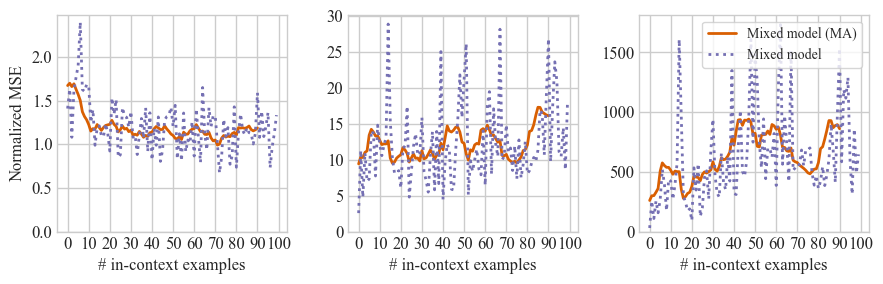

In [32]:
#y_lim_low=[0, 0, 0, 0]
#y_lim_high=[1, 5, 10, 0.4]

subdict={}
for outer_key, inner_dict in eval_calculations.items():
    if 'model0' in inner_dict:
        subdict[outer_key] = {'model0' : inner_dict['model0']}
plot_results_horizontal_individual(different_plots=subdict,
            configs=changeable_config,
            task_args=task_args,
            data_args=data_args,
            type='task',
            limit_y=False,
            head_dir=head_dir,
            smooth=True,
            width=9,
            height=3,
            )

In [33]:
num_layers = 12
num_heads = 8
attention_mask = torch.ones((num_layers, num_heads))

# Ignoring important attention heads (layer, head)
final_list_tuple = [(12,8), (10, 4), (8,7), (1,1), (7,1), (2,7), (3,8)]

for layer_head in final_list_tuple:
    attention_mask[(layer_head[0]-1), (layer_head[1]-1)] = 0

attention_mask = attention_mask.type(torch.ByteTensor)

In [34]:
different_plots, configs = run_evaluation(subset_models=model_selection,
                   task_args=task_args,
                   data_args=data_args,
                   seed=seed,
                   att_mask=attention_mask)

Conducting evaluation on hermite_regression with degree of  1 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  2 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  3 

Mixed Hermite Polynomial evaluated on Standard gaussian distribution


In [35]:
# Select models specified in previous cell
eval_calculations = copy.deepcopy(different_plots)
changeable_config = copy.deepcopy(configs)
models_you_want = 'model0'

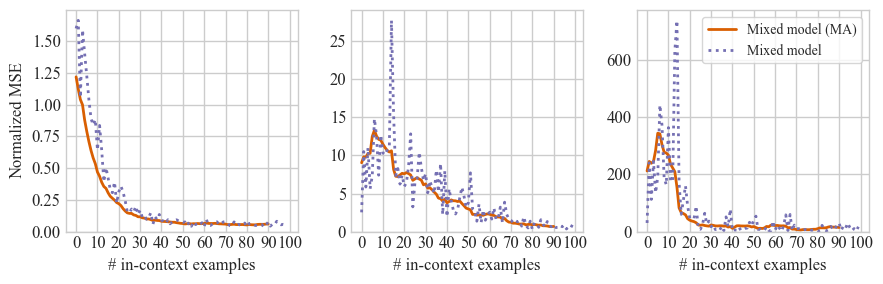

In [36]:
#y_lim_low=[0, 0, 0, 0]
#y_lim_high=[1, 5, 10, 0.4]

subdict={}
for outer_key, inner_dict in eval_calculations.items():
    if 'model0' in inner_dict:
        subdict[outer_key] = {'model0' : inner_dict['model0']}
plot_results_horizontal_individual(different_plots=subdict,
            configs=changeable_config,
            task_args=task_args,
            data_args=data_args,
            type='task',
            limit_y=False,
            head_dir=head_dir,
            smooth=True,
            width=9,
            height=3,
            )